**Name:** Hasan Iqbal

**CMS ID:** 364260

**Email:** hiqbal.msds21seecs@seecs.edu.pk

**Github Link:** https://github.com/hasaniqbal777/Fruit-Detection

**Instructor**: Dr. Muhammad Moazam Fraz

**Course**: Computer Vision CS-867

## Import Modules

In [3]:
import os
import time
import pathlib
import random
from xml.etree import ElementTree

# Data Science modules
import cv2
import numpy as np
import pandas as pd
import torch as torch

# Modules for data augmentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Modules for model training
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Modules for model evaluation
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Modules for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms

## Loading Data

In [4]:
class Dataset(torch.utils.data.Dataset):
    """
    Custom dataset class for loading
    images and annotations from a directory.
    Reference: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    # Arguments
        files_dir: Directory containing images and annotations.
        width: Width of the images.
        height: Height of the images.
        transforms: Image transformations.

    # Returns
        img_res: Resized image.
        target: Dictionary containing bounding boxes, labels, areas, iscrowd, and image_id.
    """

    def __init__(self, files_dir: str, width: int, height: int, transforms=None):
        self.files_dir = files_dir
        self.height = height
        self.width = width

        # Image transformations
        self.transforms = transforms

        # Load all image filenames
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                     if image[-4:] == '.jpg']

        # Load all classes
        self.classes = ['_', 'apple', 'banana', 'orange']

    def __getitem__(self, idx):
        """
        Returns a single image and its corresponding annotations.

        # Arguments
            idx: Index of the image.

        # Returns
            img: a PIL Image of size (H, W).
            target: a dict containing the following fields:
                boxes (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
                labels (Int64Tensor[N]): the label for each bounding box. 0 represents always the background class.
                image_id (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
                area (Tensor[N]): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
                iscrowd (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation.
                (optionally) masks (UInt8Tensor[N, H, W]): The segmentation masks for each one of the objects
                (optionally) keypoints (FloatTensor[N, K, 3]): For each one of the N objects, it contains the K keypoints in [x, y, visibility] format, defining the object. visibility=0 means that the keypoint is not visible. 
        """

        # Create image path
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # Read image and resize using OpenCV
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img,
                               cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb,
                             (self.width, self.height),
                             cv2.INTER_AREA)

        # Normalize image
        img_res /= 255.0

        # Create annotation path
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)

        # Read annotation file
        boxes = []
        labels = []
        tree = ElementTree.parse(annot_file_path)
        root = tree.getroot()

        wt = img.shape[1]
        ht = img.shape[0]

        # Loop through all objects in the annotation file
        for member in root.findall('object'):
            # Add label
            labels.append(self.classes.index(member.find('name').text))

            # Add bounding box coordinates
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            # Normalize bounding box coordinates
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height

            # Add bounding box coordinates to list
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        # Boxes tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Compute areas
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # iscrowd tensor (default value is 0)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        # Labels tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Create target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["image_id"] = torch.tensor([idx])

        # Apply transformations
        if self.transforms:
            sample = self.transforms(image=img_res,
                                     bboxes=target['boxes'],
                                     labels=labels)

            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        # Return image and target
        return img_res, target

    def __len__(self):
        """
        Returns the total number of images in the dataset.
        """
        return len(self.imgs)


def detect_extension(filename: str) -> str:
    """Detects the extension of a file."""
    try:
        extension = os.path.splitext(filename)[-1]
        if extension == '':
            raise ValueError
        return extension

    except ValueError as err:
        raise ValueError("No extension found for file %s", filename) from err


In [5]:
# Creating Data Transformer for Training and Validation
def train_transform():
    return A.Compose([A.HorizontalFlip(0.5),
                      A.VerticalFlip(0.3),
                      ToTensorV2(p=1.0)],
                     bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Creating Data Transformer for Testing
def test_transform():
    return A.Compose([ToTensorV2(p=1.0)],
                     bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [6]:
# Image Directory
img_dir = '/kaggle/input/fruit-object-detection/data'

# Data Groups
grps = ["train", "test"]

# Class Names
class_names = ['_', 'apple', 'banana', 'orange']

# Train and Test Data
train_dir = '/kaggle/input/fruit-object-detection/data/train'
dataset = Dataset(train_dir, 224, 224, transforms=train_transform())
print('Images in train dataset =', len(dataset))

test_dir = '/kaggle/input/fruit-object-detection/data/test'
test_dataset = Dataset(test_dir, 224, 224, transforms=test_transform())
print('Images in test dataset =', len(test_dataset))

Images in train dataset = 240
Images in test dataset = 60


## Visualize the data

In [7]:
def plot_img_bbox(img, target):
    """
    Plots an image and its bounding boxes.

    Args:
        img (PIL.Image or torch.Tensor): Image to plot.
        target (dict): Dictionary containing the bounding boxes.
    """
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(3, 3)

    # Convert tensor to PIL image
    if isinstance(img, torch.Tensor):
        img = transforms.ToPILImage()(img).convert('RGB')

    # Plot image
    a.imshow(img)

    # Get bounding boxes
    boxes = target['boxes']

    # Convert tensor to list
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()

    # Plot bounding boxes
    for box in (boxes):
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth=2,
                                 edgecolor='r',
                                 facecolor='none')
        a.add_patch(rect)

    plt.show()

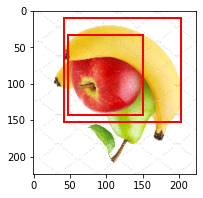

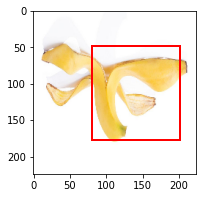

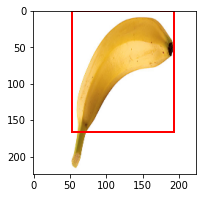

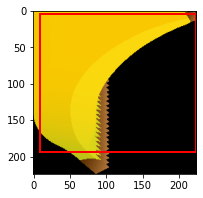

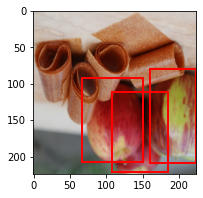

In [8]:
# Selecting some random images from the train dataset
random_images = [dataset[i] for i in random.sample(range(0, len(dataset)), 5)]
for img, target in random_images:
    plot_img_bbox(img, target)

## Data Preprocessing 
**Model** : Faster R-CNN model with a ResNet-50-FPN backbone 

**Reference** : https://arxiv.org/abs/1506.01497

In [9]:
# Sets the seed for generating random numbers
torch.manual_seed(42)
np.random.seed(42)

# Randomly shuffle the training data
indices = np.random.permutation(len(dataset)).tolist()

In [10]:
# Split the dataset into training and validation - 80% training, 20% validation
test_split = 0.2
tsize = len(dataset) - int(len(dataset)*test_split)

train_dataset = torch.utils.data.Subset(dataset, indices[:tsize])
print('Images in train dataset =', len(train_dataset))
val_dataset = torch.utils.data.Subset(dataset, indices[tsize:])
print('Images in validation dataset =', len(val_dataset))

Images in train dataset = 192
Images in validation dataset = 48


{'boxes': tensor([[ 87.4039,  46.5569, 185.7882, 152.8471]]), 'labels': tensor([3]), 'area': tensor([10457.2881]), 'iscrowd': tensor([0]), 'image_id': tensor([226])}


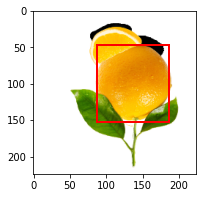

In [11]:
# collate_fn receives a list of tuples if your __getitem__ function from a Dataset subclass returns a tuple, 
# or just a normal list if your Dataset subclass returns only one element
def collate_fn(batch):
    return tuple(zip(*batch))

# Data Loaders for Training, Validation and Testing
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=5, shuffle=True, num_workers=2, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Number of training and testing batches
n_batches, n_batches_test = len(train_loader), len(test_loader)

# Visualize a batch of training data
images, targets = next(iter(train_loader))
print(targets[0])
plot_img_bbox(images[0], targets[0])

In [12]:
# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Number of classes
num_classes = len(class_names)

# Get the model using our helper function
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained heads with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
# Move model to the right device
model.to(device)

# Construct an SGD optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# And a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [13]:
EPOCHS = 35
metric = MeanAveragePrecision()

In [14]:
# History of loss values
train_loss_history = []
val_map_history = []

# Training Loop 
for epoch in range(1, EPOCHS + 1):
    print(f"Starting epoch {epoch} of {EPOCHS}")

    # Start training
    time_start = time.time()

    # Reset the metric at the start of each epoch
    loss_accum = 0.0
    loss_classifier_accum = 0.0
    
    # Train Model
    model.train()

    # Iterate over the training data and generate predictions
    for batch_idx, (images, targets) in enumerate(train_loader, 1):
        # Predict
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Compute loss
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backprop and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging and metric update
        loss_accum += loss.item()
        loss_classifier_accum += loss_dict['loss_classifier'].item()

        # Print progress
        if batch_idx % 500 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}.")

    # Update the learning rate
    lr_scheduler.step()

    # Train losses
    train_loss = loss_accum / n_batches

    # train_loss_mask = loss_mask_accum / n_batches
    train_loss_classifier = loss_classifier_accum / n_batches
    
    # Calculate elapsed time
    elapsed = time.time() - time_start

    # Save model
    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d} / {EPOCHS:2d}]"
    print(f"{prefix} Train loss: {train_loss:7.3f} [{elapsed:.0f} secs]", end=' | ')
    train_loss_history.append(train_loss)
    
    # Validation
    preds_single = []
    targets_single = []

    # Iterate over the validation data and generate predictions
    for batch_idx, (images, targets) in enumerate(val_loader, 1):
        # Predict
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        targets_single.extend(targets)

        # Model Evaluation
        model.eval()

        # Disable gradient calculation and calculate predictions
        with torch.no_grad():
            pred = model(images)
        preds_single.extend(pred)
    
    # Update the metric
    metric.update(preds_single, targets_single)
    batch_map = metric.compute()
    
    # Print the metric
    print(f"Val mAP: {batch_map['map']}")
    val_map_history.append(batch_map['map'])

Starting epoch 1 of 35
[Epoch  1 / 35] Train loss:   0.464 [28 secs] | Val mAP: 0.36775442957878113
Starting epoch 2 of 35
[Epoch  2 / 35] Train loss:   0.240 [22 secs] | Val mAP: 0.4421584904193878
Starting epoch 3 of 35
[Epoch  3 / 35] Train loss:   0.179 [22 secs] | Val mAP: 0.49566590785980225
Starting epoch 4 of 35
[Epoch  4 / 35] Train loss:   0.143 [22 secs] | Val mAP: 0.5356327295303345
Starting epoch 5 of 35
[Epoch  5 / 35] Train loss:   0.135 [22 secs] | Val mAP: 0.5563124418258667
Starting epoch 6 of 35
[Epoch  6 / 35] Train loss:   0.127 [22 secs] | Val mAP: 0.5691625475883484
Starting epoch 7 of 35
[Epoch  7 / 35] Train loss:   0.125 [22 secs] | Val mAP: 0.5803408026695251
Starting epoch 8 of 35
[Epoch  8 / 35] Train loss:   0.121 [22 secs] | Val mAP: 0.58938068151474
Starting epoch 9 of 35
[Epoch  9 / 35] Train loss:   0.122 [22 secs] | Val mAP: 0.5960142016410828
Starting epoch 10 of 35
[Epoch 10 / 35] Train loss:   0.121 [22 secs] | Val mAP: 0.6026656031608582
Starting 

## Evaluation and Testing

In [22]:
print(f"Validation mAP: {max(val_map_history)}")

Validation mAP: 0.6390011310577393


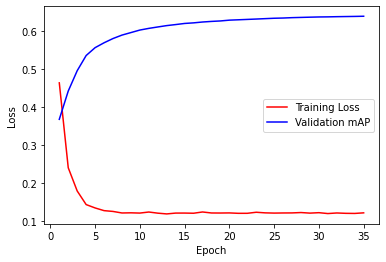

In [18]:
# Create count of the number of epochs
epoch_count = range(1, len(train_loss_history) + 1)

# Visualize loss history
plt.plot(epoch_count, train_loss_history, 'r-')
plt.plot(epoch_count, val_map_history, 'b-')
plt.legend(['Training Loss', 'Validation mAP'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [19]:
metric_test = MeanAveragePrecision()

preds_single = []
targets_single = []

for batch_idx, (images, targets) in enumerate(test_loader, 1):

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    targets_single.extend(targets)

    model.eval()
    with torch.no_grad():
        pred = model(images)

    preds_single.extend(pred)

metric_test.update(preds_single, targets_single)
test_map = metric.compute()

print(f"Test mAP: {test_map['map']}")

Test mAP: 0.6390011310577393


{'boxes': tensor([[ 53.0133,  58.6900, 130.6667, 160.4192],
        [  8.9600,  21.5197,  78.4000, 108.5764],
        [100.0533,  22.4978, 181.4400, 112.4891],
        [ 79.8933, 123.2489, 161.2800, 224.0000],
        [154.5600, 134.9869, 222.5067, 224.0000]]), 'labels': tensor([1, 1, 1, 1, 1]), 'area': tensor([7899.6167, 6045.2217, 7324.0889, 8199.7949, 6048.1440]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'image_id': tensor([0])}


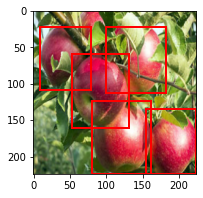

In [23]:
images, targets = next(iter(test_loader))
print(targets[0])
plot_img_bbox(images[0], targets[0])

{'boxes': tensor([[ 23.9556,  56.9333, 199.4222, 222.7556]]), 'labels': tensor([1]), 'area': tensor([29096.2734]), 'iscrowd': tensor([0]), 'image_id': tensor([2])}


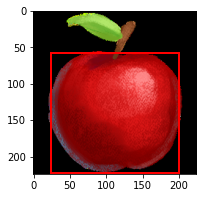

In [25]:
images, targets = next(iter(test_loader))
print(targets[2])
plot_img_bbox(images[2], targets[2])